In [147]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.stats import mode,zscore
from matplotlib import pyplot as plt


data = pd.read_json("../../data.json")
print(len(data))
try:
    data=data[data[zscore(data["a2a1"]) <2.5]][data[zscore(data["a3a2"]) <2.5]][data[zscore(data["a3a1"]) <2.5]]
except: pass
print(len(data))
data.sample(2)

19306
19306


,index,mac,timestamp,no,rssi,raw,frequency,iq,angle,distance,capture,ref,a1,a2,a3,a2a1,a3a2,a3a1
16657,171,c300000a7a46,2024-11-10 17:36:41.365000+00:00,0,-49,0201061bff3906cafb0114f9ffe9ff0701000000000000...,2426,"[147, 60, -98, 128, -120, -112, 130, -91, 59, ...",75,155.291427,camila,"[0.3875238058, 2.224222668, -2.3906635912, -0....","[2.5519666748, 0.3749322988, -1.6593217455, 2....","[-0.6411087689, -2.9783523708, 1.1968544068, -...","[2.9576491971000003, 0.9067501640000001, -1.36...","[3.0901098635, 2.9299006375000003, 2.856176152...","[-2.6844273413, -2.3980827724, -2.5613268396, ...","[0.4056825222, 0.5318178651000001, 0.294849312..."
1419,27,c300000a7a48,2024-10-04 17:25:41.567000+00:00,0,-44,0201061bff3906cafb01140000ffec0100000000000000...,2402,"[1, 194, -186, -28, 66, -178, 167, 90, -115, 1...",120,100.000000,tw,"[1.5656417333000001, -2.9921769437, -1.2157247...","[-0.41426917550000003, -2.708747624, 1.3350057...","[-1.9770906367, 2.1872769864, -0.0784901026, -...","[-3.063736164, 1.0401564658, -1.1575791084, 2....","[-1.5628214612, -1.3871606968, -1.413495869100...","[-1.0866455273, -1.1471205206, -1.0790890058, ...","[-2.6494669885, -2.5342812173, -2.492584875, -..."


# PD in each line and Post-Filtering

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error

tsamples =[]
tlabels =[]

vsamples=[]
vlabels=[]

tdataset, vdataset = train_test_split(data[data["capture"]== "tw"],test_size=0.2)

for row in tdataset.iterrows():
    for i in range(len(row[1]["a2a1"])):
        tsamples.append([
            row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]
        ])
        tlabels.append(row[1]["angle"])

for row in vdataset.iterrows():
    for i in range(len(row[1]["a2a1"])):
        vsamples.append([
            row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]
        ])
        vlabels.append(row[1]["angle"])

X_train = tsamples
y_train = [label//15 for label in tlabels ]

X_test = vsamples
y_test = [label//15 for label in vlabels ]


array_names= ([str(name) for name in range(0,180+15,15)])

In [106]:

#Splitting the data into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#Creating an XGBoost classifier
model = xgb.XGBRegressor(enable_categorical=True)

#Training the model on the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [107]:
#Making predictions on the test set
predictions = model.predict(X_test)

#Calculating accuracy
mae =mean_absolute_error(y_test, predictions)
mse =mean_squared_error(y_test, predictions)

print(f"{mae=}\n")
print(f"{mse=}\n")

mae=0.319117102879277

mse=0.677275412142263



In [ ]:
results_labels= []
results_values = []
for row in vdataset.iterrows():
    pred=[]
    for i in range(len(row[1]["a2a1"])):
        pred.append(model.predict([[row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]],])[0])
    results_labels.append((row[1]["angle"]//15))
    results_values.append(np.mean(pred))

XGBoostError: [21:23:20] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\predictor\cpu_predictor.cc:789: Check failed: m->NumColumns() == model.learner_model_param->num_feature (1 vs. 3) : Number of columns in data must equal to trained model.

In [104]:
#Calculating accuracy
mae =mean_absolute_error(results_labels, results_values)
mse =mean_squared_error(results_labels, results_values)

print(f"{mae=}\n")
print(f"{mse=}\n")

mae=2.507009920740481

mse=9.492304703704919



In [25]:
results = {str(l):[] for l in set(vlabels)}

for row in vdataset.iterrows():
    pred=[]
    for i in range(len(row[1]["a2a1"])):
        pred.append(model.predict([[row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]],])[0])
    results[str(row[1]["angle"])].append(np.mean(pred)*15)

In [26]:
# for key, values in results.items():
#     print(f"Angulo {key}\n" )
#     print(f"\t media = {np.mean(values)} \t std = {np.std(values)} \t variance ={np.var(values)} ")

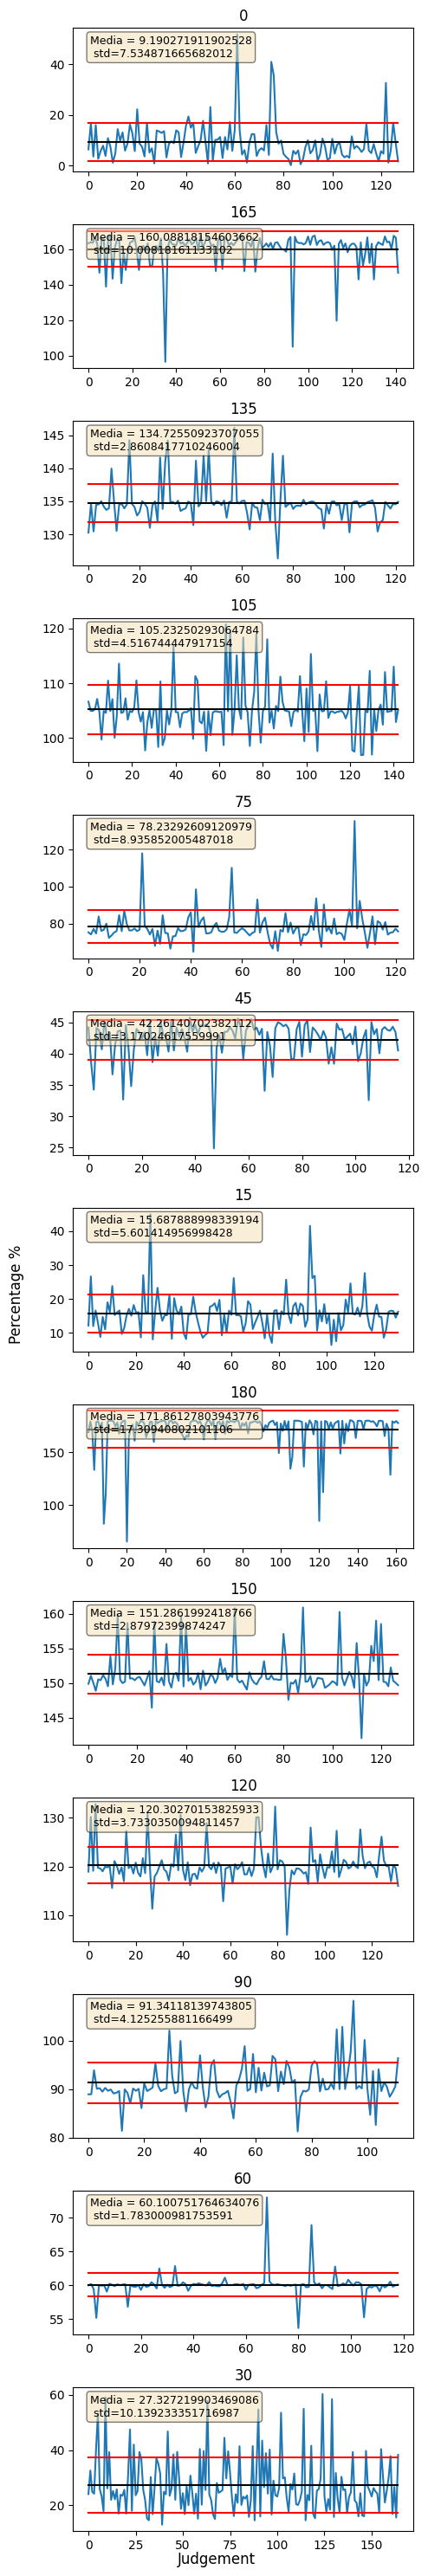

In [27]:
fig, ax = plt.subplots(len(set(results.keys())),figsize=(5,30))
fig.set_tight_layout(True)

fig.supylabel("Percentage %")
fig.supxlabel("Judgement")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i, pair in enumerate(results.items()):
    ax[i].title.set_text(pair[0])
    ax[i].plot(pair[1])
    ax[i].plot([np.mean(pair[1])]*len(pair[1]),'k')
    ax[i].plot([np.mean(pair[1])+np.std(pair[1])]*len(pair[1]),'r')
    ax[i].plot([np.mean(pair[1])-np.std(pair[1])]*len(pair[1]),'r')

    ax[i].text(0.05, 0.95, f"Media = {np.mean(pair[1])}\n std={np.std(pair[1])}", transform=ax[i].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)


In [28]:
results = {str(l):[] for l in set(vlabels)}

for row in vdataset.iterrows():
    pred=[]
    for i in range(len(row[1]["a2a1"])):
        pred.append(model.predict([[row[1]["a2a1"][i], row[1]["a3a2"][i], row[1]["a3a1"][i]],])[0])
    pred = np.array(pred)

    pred = pred[zscore(pred)<2]
    results[str(row[1]["angle"])].append(np.mean(pred)*15)
    

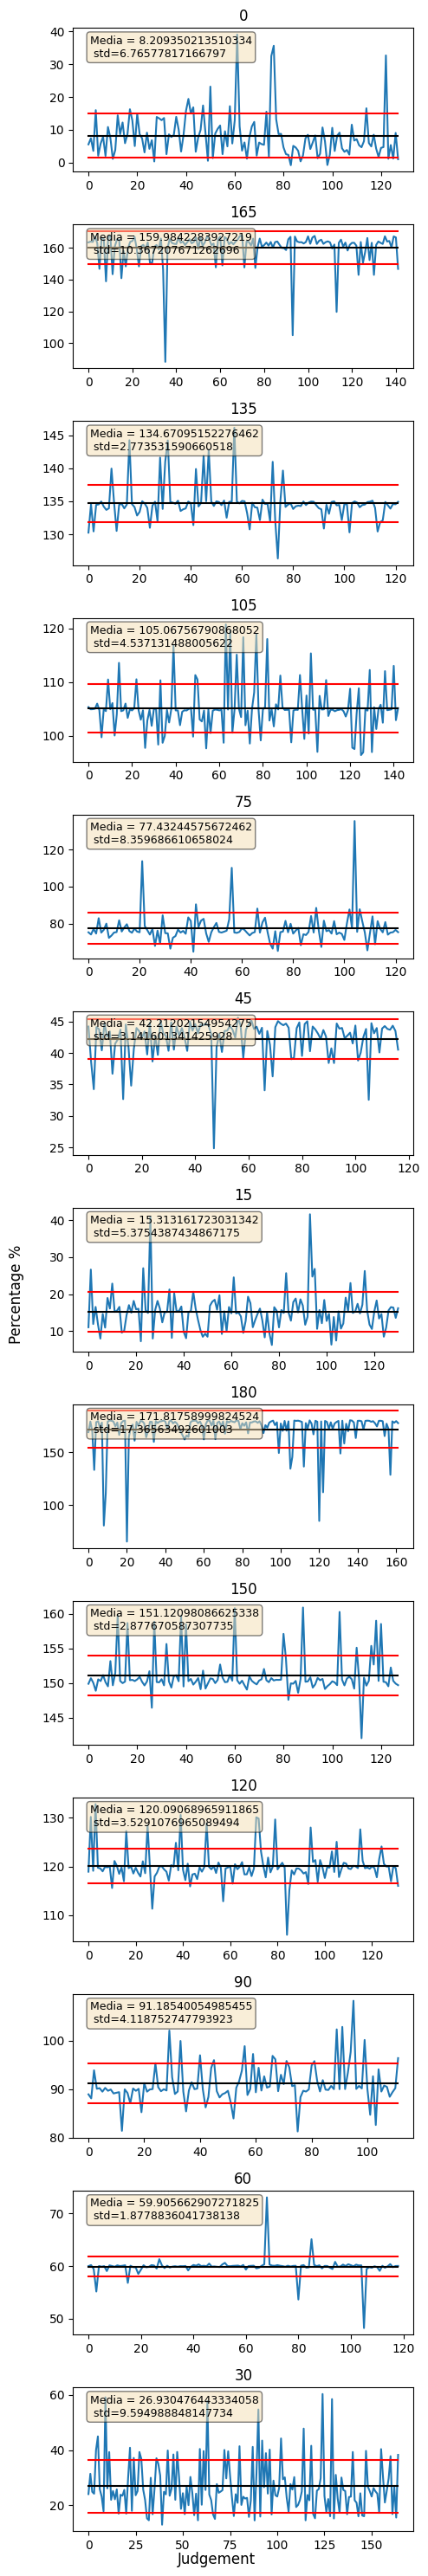

In [29]:
fig, ax = plt.subplots(len(set(results.keys())),figsize=(5,30))
fig.set_tight_layout(True)

fig.supylabel("Percentage %")
fig.supxlabel("Judgement")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for i, pair in enumerate(results.items()):
    ax[i].title.set_text(pair[0])
    ax[i].plot(pair[1])
    ax[i].plot([np.mean(pair[1])]*len(pair[1]),'k')
    ax[i].plot([np.mean(pair[1])+np.std(pair[1])]*len(pair[1]),'r')
    ax[i].plot([np.mean(pair[1])-np.std(pair[1])]*len(pair[1]),'r')

    ax[i].text(0.05, 0.95, f"Media = {np.mean(pair[1])}\n std={np.std(pair[1])}", transform=ax[i].transAxes, fontsize=9,
        verticalalignment='top', bbox=props)


AttributeError: 'numpy.ndarray' object has no attribute 'contains'

In [ ]:

zscore(data["a2a1"])

TypeError: unsupported operand type(s) for /: 'list' and 'int'

dtype('O')